## LSTM-Image-Captioning

>Python版本: Python3
环境: windows
IDE: Jupyter Notebook
数据集: Flickr8k

之前的实现是跟着cs231n的课程来的，使用的是coco数据集，比较大，这次试着使用比较小的flickr8k数据集，并采用keras+tensorflow作为较高层次的抽象，来实现网络功能。


In [121]:
import os 
import sys

FLICKR8K_BASE = "../Datasets/Flickr8k"
FLICKR8K_DATASET = "../Datasets/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset"
FLICKR8K_TEXT = "../Datasets/Flickr8k/Flickr8k_text"

token = os.path.join(FLICKR8K_TEXT, "Flickr8k.token.txt")
print(token)

def load_captions(filename):
    captions = []
    with open(filename, 'r') as f:
#         lines = f.readlines()
        tmp = 1
        for line in f:
            line_data = line.strip().split('\n')
            line_data = ''.join(line_data)
            captions.append(line_data)
            if tmp:
                print(type(line_data))
                print(line_data)
                tmp =0 
    return captions

captions = load_captions(token)
print(len(captions))

../Datasets/Flickr8k/Flickr8k_text\Flickr8k.token.txt
<class 'str'>
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
40460


In [111]:
print(captions[:10])

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .', '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .']


和coco数据一样，一张图片拥有5个描述。现在使用数据字典来将每幅图片和其对应的描述整合在一起。便于之后的使用。这里将图片的名称作为主键。

In [29]:
print(type(captions[0]))
# print(captions.split('\t'))

<class 'str'>


In [40]:

def load_data(captions):
    d = {}
    tmp = 1
    for i, item in enumerate(captions):
        item = item.split('\t')
        item[0] = item[0][:len(item[0])-2]  # 去掉 #n ，得到图片的名称xxx.jpg
        item[0] = ''.join(item[0])
        if tmp:
            print(item[0])
            print('----')
            print(item[1])
            tmp += 1
            if tmp == 5:
                tmp = 0
        
        if item[0] in d:
            d[item[0]].append(item[1])   # 文件名称作为键，描述作为值, 有多个则扩展
        else:
            d[item[0]] = [item[1]]       # 有单个则添加
    return d

dic = load_data(captions)
print(len(dic))

1000268201_693b08cb0e.jpg
----
A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg
----
A girl going into a wooden building .
1000268201_693b08cb0e.jpg
----
A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg
----
A little girl climbing the stairs to her playhouse .
8092


In [41]:
dic['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [42]:
train_images_file = os.path.join(FLICKR8K_TEXT, "Flickr_8k.trainImages.txt")
print(train_images_file)

train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
print(len(train_images))

../Datasets/Flickr8k\Flickr8k_text\Flickr_8k.trainImages.txt
6000


In [ ]:
def load_images(split_name='train'):
    images = set()
    if split_name is not in set('train', 'dev','test'):
        print('Data set types: train, dev, test')
        return images
        
    images_file = os.path.join(FLICKR8K_TEXT, "Flickr_8k.{0}Images.txt".format(split_name))
    print(images_file)
    images = set(open(images_file, 'r').read().strip().split('\n'))
                                    
    print(len(images))
    return images

train_images = load_images('train')
tmp_cnt =0
for e in train_images:
    print(e, type(e))
    tmp_cnt += 1
    if tmp_cnt==5:
        break

In [45]:
val_images = load_images('dev')
print(len(val_images))

../Datasets/Flickr8k\Flickr8k_text\Flickr_8k.devImages.txt
1000
1000


In [46]:
test_images = load_images('test')

../Datasets/Flickr8k\Flickr8k_text\Flickr_8k.testImages.txt
1000


In [49]:
def set2list(s):
    return [e for e in s]

s0 = set([1, 3, 3, 4])
l0 = set2list(s0)
print(l0)

[1, 3, 4]


In [129]:
from PIL import Image

def open_image(image_name,base_dir=FLICKR8K_DATASET):
#     image_file = base_dir+'/'+image_name
    image_file = os.path.join(base_dir, image_name)
    print(image_file)
    Image.open(image_file)

def img_full_url(image_name, base_dir=FLICKR8K_DATASET):
    image_file = os.path.join(base_dir, image_name)
    return image_file
    

train_imgs = set2list(train_images)
print(train_imgs[0])
open_image(train_imgs[0])
# Image.open("../Datasets/Flickr8k/Flickr8k_Dataset/Flickr8k_Dataset/667626_18933d713e.jpg")

2234910971_80e0325918.jpg
../Datasets/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset\2234910971_80e0325918.jpg


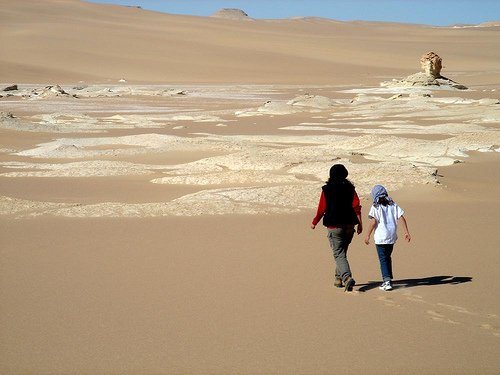

In [127]:
Image.open(os.path.join(FLICKR8K_DATASET, train_imgs[0]))

现在需要使用CNN来预训练模型，首先要对输入图像进行预处理。

In [148]:
from keras.preprocessing import image

def preprocess_input(x):  # 将数值范围映射到0..1之间
    x /= 255.
#     x -= 0.5
#     x *= 2.
    return x

def preprocess(image_path,target_size=(299, 299)):
    img = image.load_img(image_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    x = preprocess_input(x)
    return x

In [149]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

img_full_url(train_imgs[0])
# plt.imshow(np.squeeze(preprocess(img_full_url(train_imgs[0]))))

'../Datasets/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset\\2234910971_80e0325918.jpg'

In [150]:
a = np.squeeze(preprocess(img_full_url(train_imgs[0])))

In [151]:
print(a.shape)

(299, 299, 3)


In [152]:
print(a)

[[[0.67058825 0.5647059  0.45882353]
  [0.6745098  0.5686275  0.4627451 ]
  [0.6627451  0.5568628  0.4509804 ]
  ...
  [0.5137255  0.654902   0.7882353 ]
  [0.5019608  0.654902   0.78431374]
  [0.5019608  0.654902   0.78431374]]

 [[0.6627451  0.56078434 0.45490196]
  [0.6666667  0.5647059  0.45882353]
  [0.6627451  0.56078434 0.45490196]
  ...
  [0.50980395 0.6627451  0.7921569 ]
  [0.50980395 0.6627451  0.7921569 ]
  [0.50980395 0.6627451  0.7921569 ]]

 [[0.64705884 0.57254905 0.45490196]
  [0.64705884 0.57254905 0.45490196]
  [0.64705884 0.57254905 0.45490196]
  ...
  [0.49803922 0.6745098  0.79607844]
  [0.52156866 0.6745098  0.8039216 ]
  [0.52156866 0.6745098  0.8039216 ]]

 ...

 [[0.58431375 0.4862745  0.3647059 ]
  [0.59607846 0.49803922 0.3764706 ]
  [0.6156863  0.5176471  0.39607844]
  ...
  [0.6        0.50980395 0.38431373]
  [0.6        0.50980395 0.3764706 ]
  [0.5882353  0.49803922 0.3647059 ]]

 [[0.6117647  0.5137255  0.39215687]
  [0.59607846 0.49803922 0.3764706 ]


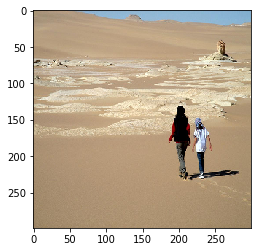

In [153]:
plt.imshow(a)

下面需要使用具体的神经网络来对图片进行处理。这里采用的是google的inception3

In [147]:
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 130s 1us/step


In [154]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

之前采用的是VGG-16网络，最后将其全连接层特征作为了LSTM的输入，其中最后的特征大小是(1, 4096)。

In [157]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

new_model = Model(new_input, hidden_layer)

# 对一张图片用inception v3进行测试
tryi = new_model.predict(preprocess(img_full_url(train_imgs[0])))
tryi.shape

(1, 2048)

这样就对图片进行了编码，encode

运用之前学过的python基础，可以用最简单也很可靠的pickle来腌制编码的数据，需要再用的使用只需要再load进来即可。

下面为特征数组的保存进行一些基本的list和.h5文件的操作。

In [158]:
np.zeros(4)

array([0., 0., 0., 0.])

In [159]:
a1 = np.ones(36)    
a2 = np.zeros(4)
a1+a2

ValueError: operands could not be broadcast together with shapes (36,) (4,) 

In [161]:
a0 = [0]*10

In [162]:
a1 = [1]*20

In [166]:
a2 = a0+a1
print(type(a2), a2)

<class 'list'> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [169]:
npa2 = np.array(a2)
print(type(npa2),npa2)

<class 'numpy.ndarray'> [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


下面尝试将numpy数组保存为数据集常用的数据格式`.hdf5`格式，并进行读写操作。

In [170]:
import h5py
import numpy as np


f = h5py.File('test_h5.h5', 'w')
N, D = 10, 512
features = np.random.randn(N, D)
print(features)

[[ 0.5561689   0.80672639  0.57031828 ... -2.35222706 -0.86344891
   0.32108566]
 [ 0.76824838  1.75834128  0.49959691 ...  1.81517903 -0.63163423
   0.21007132]
 [-1.2728684  -0.0679677  -0.21764908 ... -0.39834305  2.62776656
   0.37839697]
 ...
 [ 1.50022555 -0.32222647  0.43959529 ...  0.3277743   0.11792236
  -0.53751679]
 [-0.22788517 -0.40280643 -0.64325776 ... -0.32169121  0.25070488
  -0.64443364]
 [ 0.54583118 -0.17842557 -0.0355744  ...  0.92652333 -0.45740316
  -0.80677228]]


In [171]:
train_features = f.create_dataset("train_features", (N, D), data=features,dtype='float32')


In [172]:
print(train_features)

<HDF5 dataset "train_features": shape (10, 512), type "<f4">


写入成功，接下来来读取写入的数据。

In [182]:
fr = h5py.File('test_h5.h5', 'r+')
fr.keys()

KeysView(<HDF5 file "test_h5.h5" (mode r+)>)

In [178]:
tmp_a = fr['train_features']

In [180]:
print(type(tmp_a), tmp_a.shape,  np.asarray(tmp_a))

<class 'h5py._hl.dataset.Dataset'> (10, 512) [[ 0.5561689   0.8067264   0.5703183  ... -2.352227   -0.8634489
   0.32108566]
 [ 0.7682484   1.7583413   0.4995969  ...  1.815179   -0.63163424
   0.21007133]
 [-1.2728684  -0.0679677  -0.21764909 ... -0.39834306  2.6277666
   0.37839696]
 ...
 [ 1.5002255  -0.32222646  0.43959528 ...  0.3277743   0.11792236
  -0.5375168 ]
 [-0.22788517 -0.40280643 -0.64325774 ... -0.32169122  0.25070488
  -0.6444336 ]
 [ 0.5458312  -0.17842557 -0.0355744  ...  0.9265233  -0.45740315
  -0.8067723 ]]


In [188]:
arr1 = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
arr2 = np.array(arr1)
print(type(arr2), arr2.shape, arr2.dtype)
print(arr2)

<class 'numpy.ndarray'> (3, 3) int32
[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [184]:
tmp_d = {1:'1', 2:'2', 3:'3'}
tmp_k = 4
if tmp_k not in tmp_d:
    print('<unk>')
else:
    print(tmp_d[tmp_k])

<unk>


In [189]:
arr1 = [[1, 2, 3], [4, 6], [7, ]]
arr2 = np.array(arr1)
print(type(arr2), arr2.shape, arr2.dtype)
print(arr2)

<class 'numpy.ndarray'> (3,) object
[list([1, 2, 3]) list([4, 6]) list([7])]


In [191]:
tmp_d = {1: np.array([[2, 3],[1, 2]]), 2: np.array([[0, 1], [1, 0]])}
print(tmp_d[1], type(tmp_d[1]))

[[2 3]
 [1 2]] <class 'numpy.ndarray'>


In [192]:
arr1 = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
arr2 = np.array(arr1)
arr2.ndim

2

In [194]:
np.array([])

array([], dtype=float64)